In [7]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp



In [6]:
model


TwoHemiRNNTanh_single_readout(
  (rnn_cell): TwoHemiRNNCellGeneral(
    (nonlinearity): Tanh()
    (w_hh_linear_ll): Linear(in_features=2, out_features=2, bias=True)
    (w_hh_linear_rr): Linear(in_features=2, out_features=2, bias=True)
    (w_hh_linear_lr): Linear(in_features=2, out_features=2, bias=False)
    (w_hh_linear_rl): Linear(in_features=2, out_features=2, bias=False)
  )
  (w_xh_linear_left_alm): Linear(in_features=2, out_features=2, bias=False)
  (w_xh_linear_right_alm): Linear(in_features=2, out_features=2, bias=False)
  (readout_linear): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_20.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)

# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()


# model.rnn_cell.w_hh_linear_ll.weight.data = torch.tensor([
#     [1.5, -0.3],
#     [-0.3, 1.5]], dtype=torch.float32).to(device)
# model.rnn_cell.w_hh_linear_ll.bias.data = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
# model.w_xh_linear_left_alm.weight.data = torch.tensor([
#     [1.0, 0.0],
#     [0.0, 1.0]
# ], dtype=torch.float32).to(device)

# model.readout_linear.weight.data = torch.tensor([
#     [1.0, -1.0, 0.0, 0.0]
# ], dtype=torch.float32).to(device)
# model.w_xh_linear_left_alm.bias.data = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
# print(bias, readout_weights, recurrent_weights)


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input_cross_hemi/n_neurons_4_random_seed_9/unfix_epoch_11/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_20.pth


In [23]:
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_simple.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels_simple.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input.shape


torch.Size([500, 125, 2])

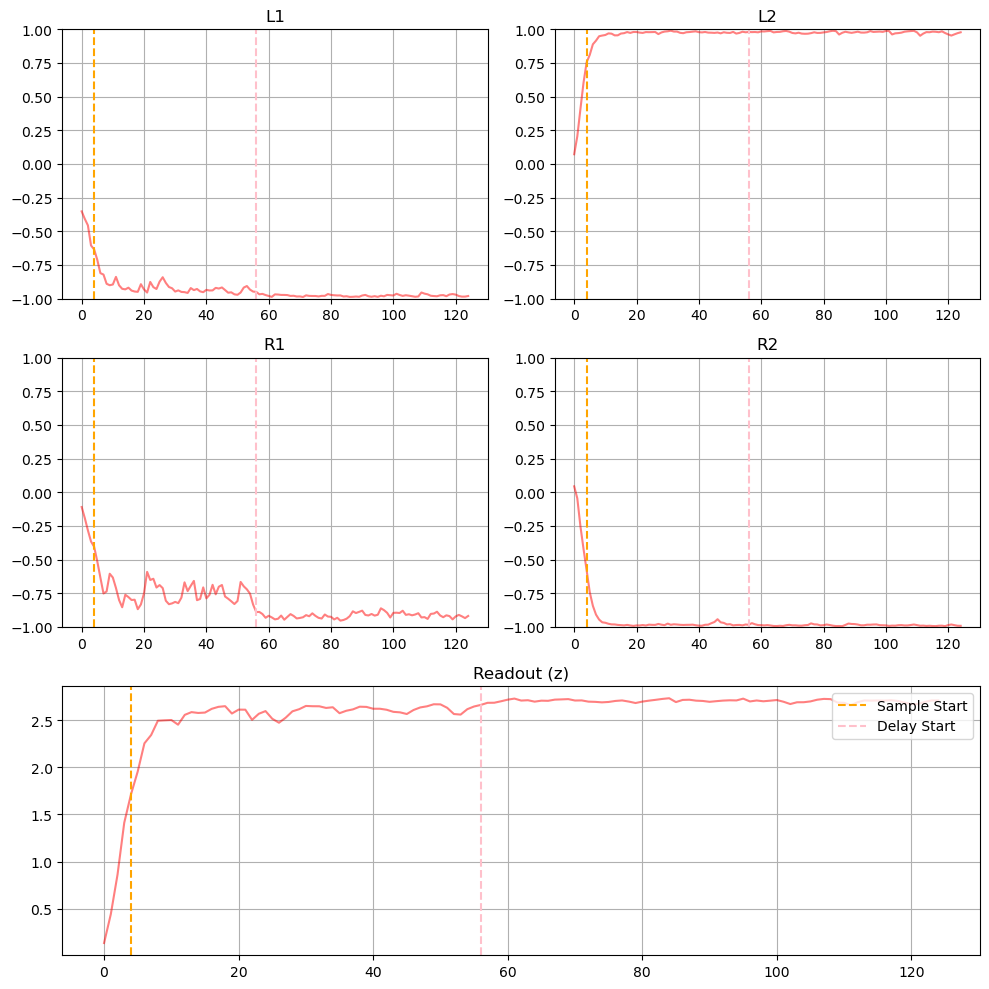

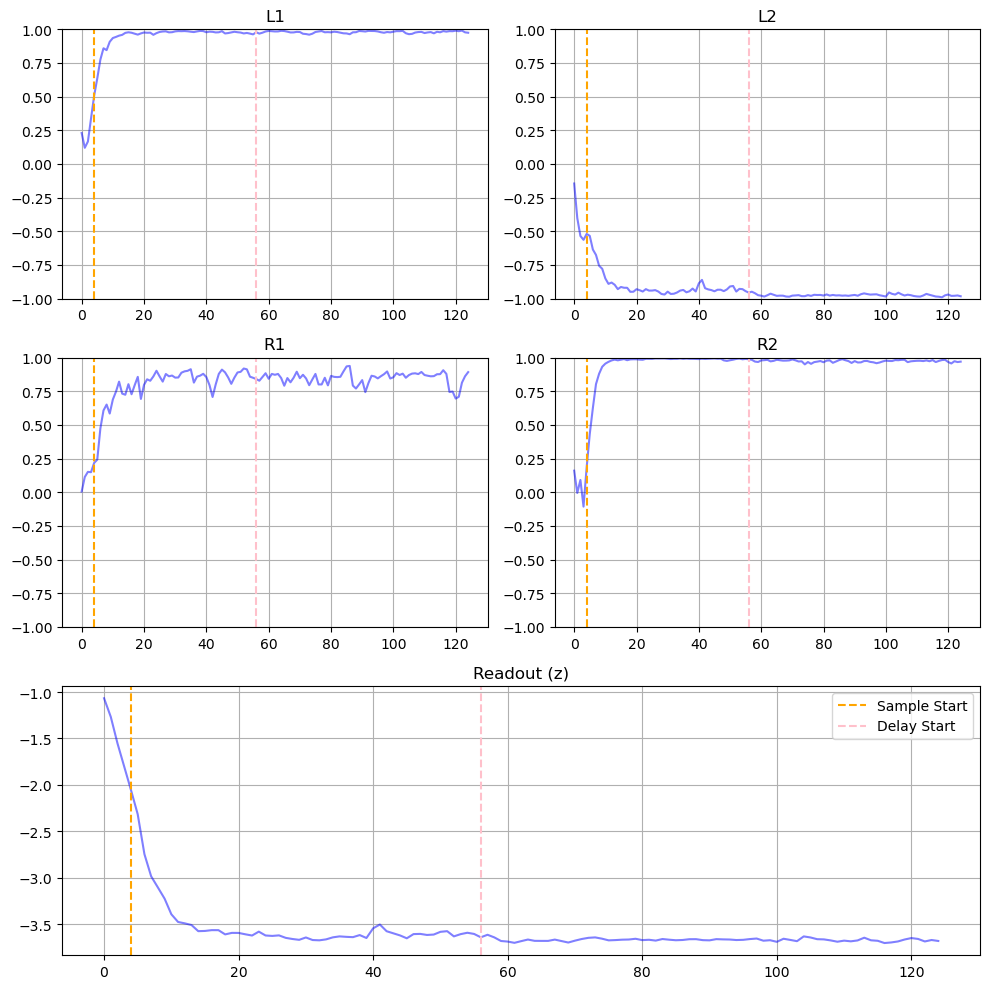

In [24]:
import matplotlib.gridspec as gridspec


# Pass input into model
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input
for i in range(1):
    l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
    r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)
    hs, zs = model(l_trial_input)
    hs_r, zs_r = model(r_trial_input)


    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])  # Make all rows same height

    titles = ['L1', 'L2', 'R1', 'R2']
    axs = []
    for i in range(4):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        ax.plot(hs[0, :, i].detach().cpu().numpy(), color='red', alpha=0.5)
        ax.set_title(titles[i])
        ax.grid(True)
        # Add vertical lines for sample_begin and delay_begin
        ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
        ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
        ax.set_ylim(-1, 1)
        axs.append(ax)

    # Add zs as a fifth subplot, centered in the third row, same aspect ratio as others
    ax_zs = fig.add_subplot(gs[2, :])
    ax_zs.plot(zs[0, :, 0].detach().cpu().numpy(), color='red', alpha=0.5)
    ax_zs.set_title('Readout (z)')
    ax_zs.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax_zs.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
    ax_zs.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

    # Optionally, add legend only to the last subplot to avoid clutter
    ax_zs.legend(loc='upper right')
    # ax_zs.set_ylim(-1, 1)
    # plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()



    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])  # Make all rows same height

    titles = ['L1', 'L2', 'R1', 'R2']
    axs = []
    for i in range(4):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        ax.plot(hs_r[0, :, i].detach().cpu().numpy(), color='blue', alpha=0.5)
        ax.set_title(titles[i])
        ax.grid(True)
        # Add vertical lines for sample_begin and delay_begin
        ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
        ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
        ax.set_ylim(-1, 1)
        axs.append(ax)

    # Add zs as a fifth subplot, centered in the third row, same aspect ratio as others
    ax_zs = fig.add_subplot(gs[2, :])
    ax_zs.plot(zs_r[0, :, 0].detach().cpu().numpy(), color='blue', alpha=0.5)
    ax_zs.set_title('Readout (z)')
    ax_zs.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax_zs.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
    ax_zs.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

    # Optionally, add legend only to the last subplot to avoid clutter
    ax_zs.legend(loc='upper right')
    # ax_zs.set_ylim(-1, 1)
    # plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()

In [25]:
l_trial_input_all.shape

torch.Size([500, 125, 2])

torch.Size([500, 125, 2])


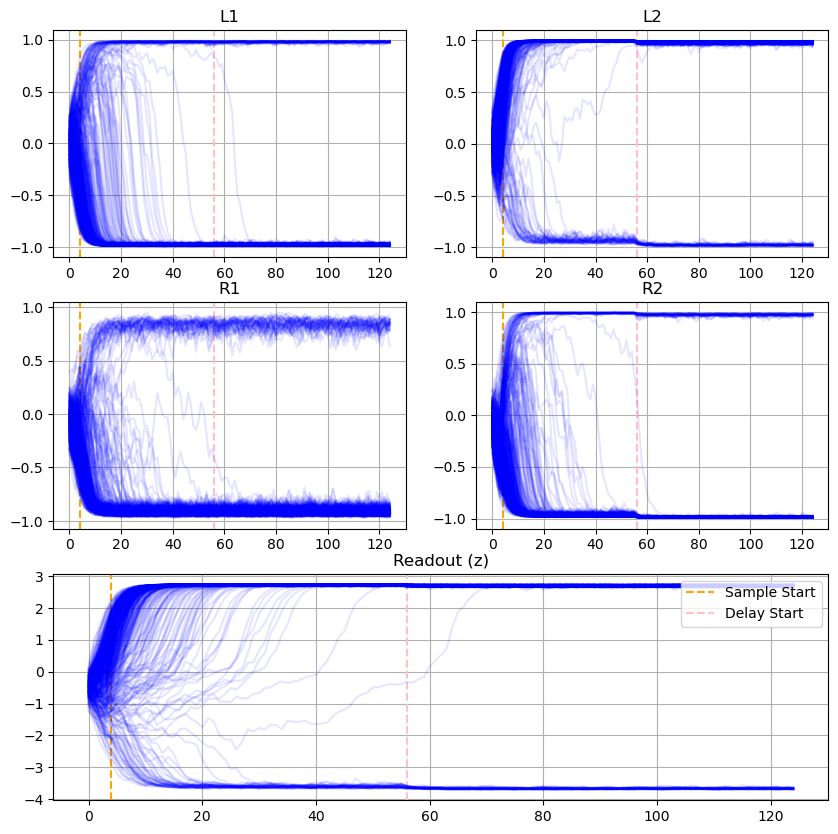

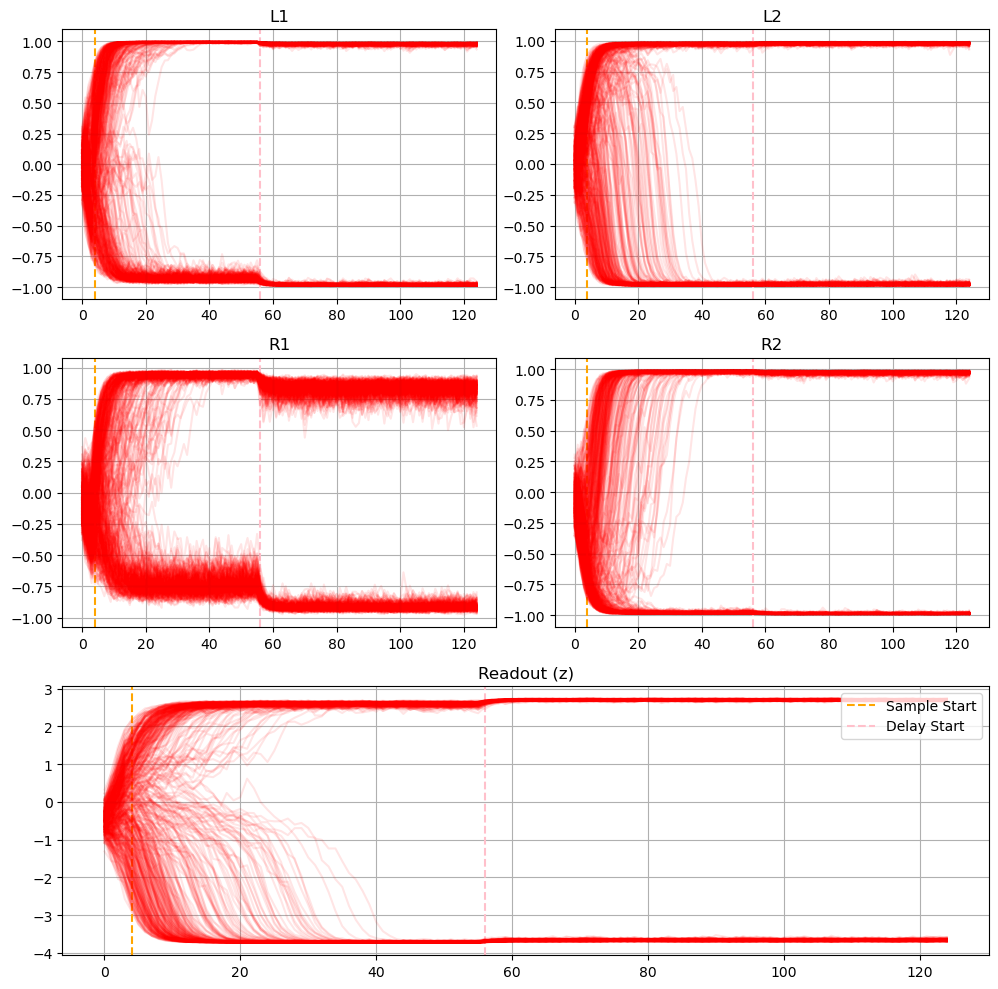

<Figure size 640x480 with 0 Axes>

In [26]:
# plot as overlay over all trials


import matplotlib.gridspec as gridspec

# Overlay all 500 trials for left and right trials individually onto the same set of subplots
# l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input

# Prepare figure and axes for left trials
fig_left = plt.figure(figsize=(10, 10))
gs_left = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
titles = ['L1', 'L2', 'R1', 'R2']
axs_left = []
for i in range(4):
    ax = fig_left.add_subplot(gs_left[i // 2, i % 2])
    ax.set_title(titles[i])
    ax.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
    ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
    axs_left.append(ax)
ax_zs_left = fig_left.add_subplot(gs_left[2, :])
ax_zs_left.set_title('Readout (z)')
ax_zs_left.grid(True)
ax_zs_left.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_zs_left.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Prepare figure and axes for right trials
fig_right = plt.figure(figsize=(10, 10))
gs_right = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
axs_right = []
for i in range(4):
    ax = fig_right.add_subplot(gs_right[i // 2, i % 2])
    ax.set_title(titles[i])
    ax.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
    ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
    axs_right.append(ax)
ax_zs_right = fig_right.add_subplot(gs_right[2, :])
ax_zs_right.set_title('Readout (z)')
ax_zs_right.grid(True)
ax_zs_right.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_zs_right.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')
print(l_trial_input_all.shape)
# Overlay all 500 trials

# l_trial_input = l_trial_input_all[trial_idx].reshape(1, exp.T, 2)
# r_trial_input = r_trial_input_all[trial_idx].reshape(1, exp.T, 2)
hs, zs = model(l_trial_input_all)
hs_r, zs_r = model(r_trial_input_all)

for trial_idx in range(500):


    # Plot left trial
    for i in range(4):
        axs_left[i].plot(hs[trial_idx, :, i].detach().cpu().numpy(), color='red', alpha=0.1)
    ax_zs_left.plot(zs[trial_idx, :, 0].detach().cpu().numpy(), color='red', alpha=0.1)

    # Plot right trial
    for i in range(4):
        axs_right[i].plot(hs_r[trial_idx, :, i].detach().cpu().numpy(), color='blue', alpha=0.1)
    ax_zs_right.plot(zs_r[trial_idx, :, 0].detach().cpu().numpy(), color='blue', alpha=0.1)

# Add legends only to the last subplot to avoid clutter
ax_zs_left.legend(loc='upper right')
ax_zs_right.legend(loc='upper right')

plt.figure(fig_left.number)
plt.tight_layout()
plt.show()

plt.figure(fig_right.number)
plt.tight_layout()
plt.show()

In [27]:
model.readout_linear.weight.data[0,:2] = torch.tensor([1, -1], dtype=torch.float32).to(device)


torch.Size([500, 125, 2])


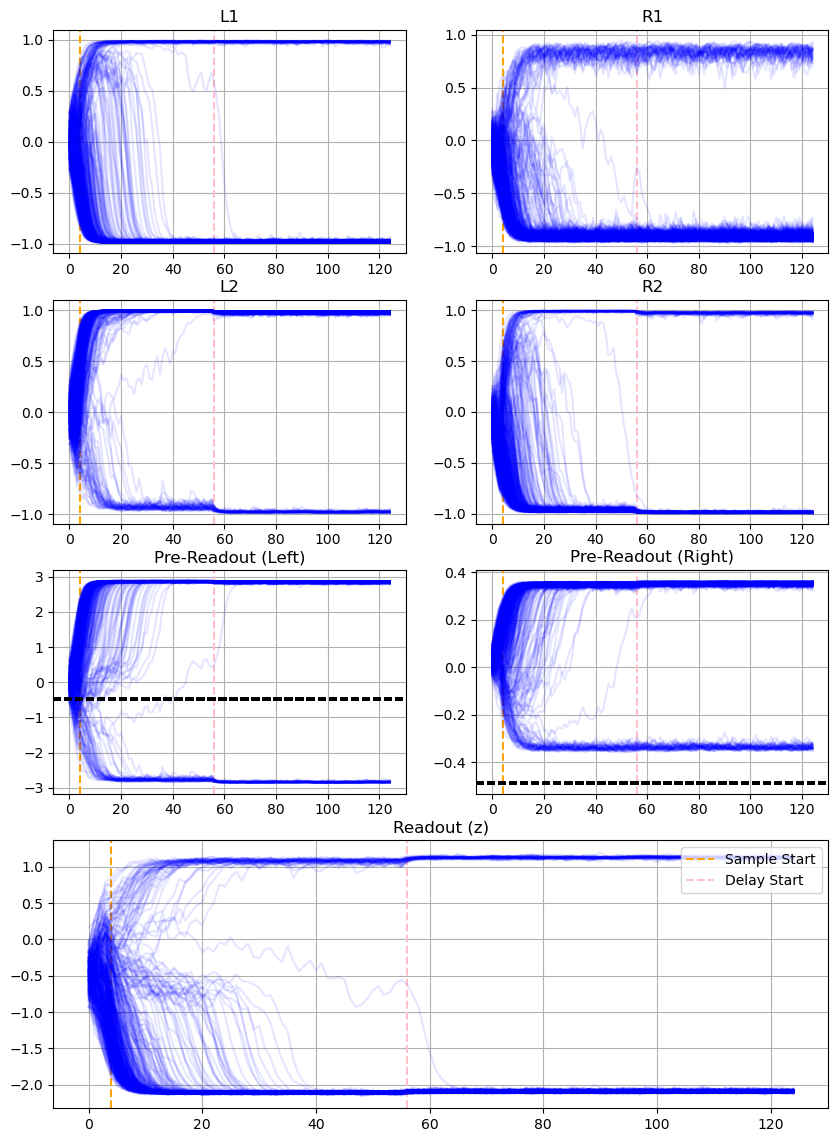

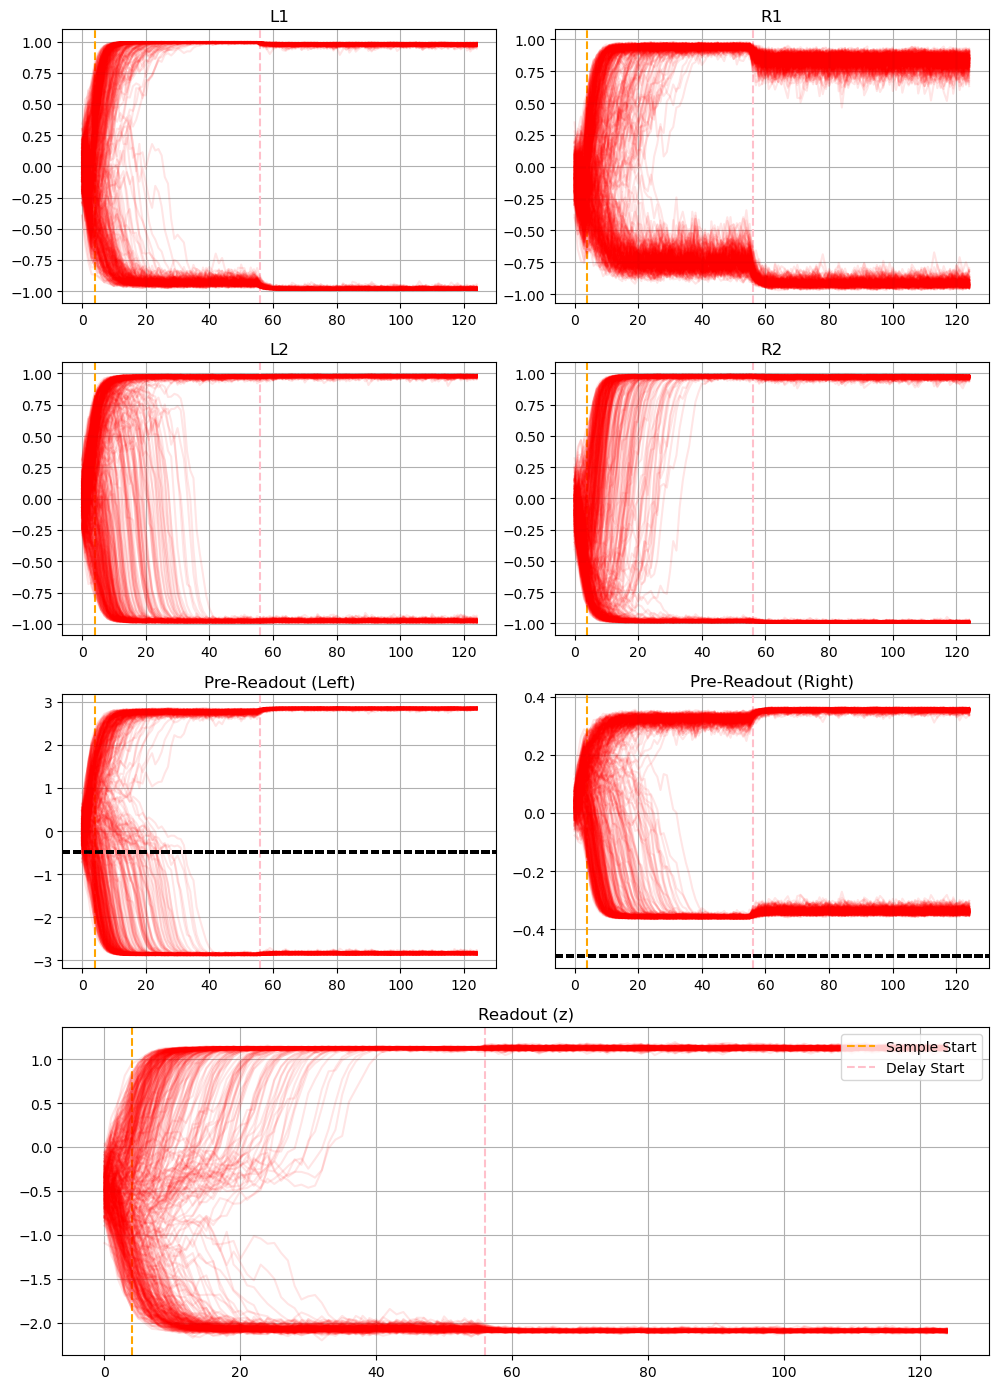

<Figure size 640x480 with 0 Axes>

In [28]:
# plot as overlay over all trials


import matplotlib.gridspec as gridspec

# Overlay all 500 trials for left and right trials individually onto the same set of subplots
# l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input

# Prepare figure and axes for left trials
fig_left = plt.figure(figsize=(10, 14))
gs_left = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.2])
titles = ['L1', 'L2', 'R1', 'R2']
axs_left = []

# Arrange L1 and L2 in the left column (col=0), R1 and R2 in the right column (col=1)
# L1: row 0, col 0; L2: row 1, col 0; R1: row 0, col 1; R2: row 1, col 1
subplot_positions = [(0, 0), (1, 0), (0, 1), (1, 1)]
for i, (row, col) in enumerate(subplot_positions):
    ax = fig_left.add_subplot(gs_left[row, col])
    ax.set_title(titles[i])
    ax.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
    ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
    axs_left.append(ax)

# Add pre-readout axes for left and right (row 2, col 0 and col 1)
ax_pre_left = fig_left.add_subplot(gs_left[2, 0])
ax_pre_left.set_title('Pre-Readout (Left)')
ax_pre_left.grid(True)
ax_pre_left.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_left.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

ax_pre_right = fig_left.add_subplot(gs_left[2, 1])
ax_pre_right.set_title('Pre-Readout (Right)')
ax_pre_right.grid(True)
ax_pre_right.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_right.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Readout axis (last row)
ax_zs_left = fig_left.add_subplot(gs_left[3, :])
ax_zs_left.set_title('Readout (z)')
ax_zs_left.grid(True)
ax_zs_left.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_zs_left.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Prepare figure and axes for right trials
fig_right = plt.figure(figsize=(10, 14))
gs_right = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.2])
axs_right = []
for i, (row, col) in enumerate(subplot_positions):
    ax = fig_right.add_subplot(gs_right[row, col])
    ax.set_title(titles[i])
    ax.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
    ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
    axs_right.append(ax)

# Add pre-readout axes for left and right (row 2, col 0 and col 1)
ax_pre_left_r = fig_right.add_subplot(gs_right[2, 0])
ax_pre_left_r.set_title('Pre-Readout (Left)')
ax_pre_left_r.grid(True)
ax_pre_left_r.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_left_r.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

ax_pre_right_r = fig_right.add_subplot(gs_right[2, 1])
ax_pre_right_r.set_title('Pre-Readout (Right)')
ax_pre_right_r.grid(True)
ax_pre_right_r.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_right_r.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Readout axis (last row)
ax_zs_right = fig_right.add_subplot(gs_right[3, :])
ax_zs_right.set_title('Readout (z)')
ax_zs_right.grid(True)
ax_zs_right.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_zs_right.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

print(l_trial_input_all.shape)
# Overlay all 500 trials

hs, zs = model(l_trial_input_all)
hs_r, zs_r = model(r_trial_input_all)

# Pre-readout: for left trials, left = hs[...,0], right = hs[...,1]
# For right trials, left = hs_r[...,0], right = hs_r[...,1]
for trial_idx in range(500):

    # Plot left trial
    for i in range(4):
        axs_left[i].plot(hs[trial_idx, :, i].detach().cpu().numpy(), color='red', alpha=0.1)

        # (hs.detach().cpu().numpy()[0] * readout_weights.flatten()).shape

    pre_left_readout = np.sum(hs[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    pre_right_readout = np.sum(hs[trial_idx, :, 2:].detach().cpu().numpy() * readout_weights.flatten()[2:], axis=1)
    ax_pre_left.plot(pre_left_readout, color='red', alpha=0.1)
    ax_pre_right.plot(pre_right_readout, color='red', alpha=0.1)
    ax_pre_left.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_pre_right.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_zs_left.plot(zs[trial_idx, :, 0].detach().cpu().numpy(), color='red', alpha=0.1)

    # Plot right trial
    for i in range(4):
        axs_right[i].plot(hs_r[trial_idx, :, i].detach().cpu().numpy(), color='blue', alpha=0.1)

    pre_left_readout = np.sum(hs_r[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    pre_right_readout = np.sum(hs_r[trial_idx, :, 2:].detach().cpu().numpy() * readout_weights.flatten()[2:], axis=1)
    ax_pre_left_r.plot(pre_left_readout, color='blue', alpha=0.1)
    ax_pre_right_r.plot(pre_right_readout, color='blue', alpha=0.1)
    ax_pre_left_r.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_pre_right_r.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_zs_right.plot(zs_r[trial_idx, :, 0].detach().cpu().numpy(), color='blue', alpha=0.1)

# Add legends only to the last subplot to avoid clutter
ax_zs_left.legend(loc='upper right')
ax_zs_right.legend(loc='upper right')

plt.figure(fig_left.number)
plt.tight_layout()
plt.show()

plt.figure(fig_right.number)
plt.tight_layout()
plt.show()

In [ ]:
model.readout_linear.weight.data


tensor([[-1.0000,  1.0000,  1.6204,  1.8570]], device='mps:0')

In [95]:
pre_left_readout = hs[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2]
np.sum(pre_left_readout, axis=1).shape

(125,)

In [91]:
(hs.detach().cpu().numpy()[0] * readout_weights.flatten()).shape

(125, 4)

In [86]:
hs


tensor([[[-0.3011, -0.0182,  0.0335, -0.1299],
         [-0.1440, -0.2818, -0.1722, -0.3254],
         [-0.1027, -0.5753, -0.4331, -0.3886],
         ...,
         [-0.2896, -0.5428, -0.8737, -0.9065],
         [-0.2438, -0.6106, -0.8752, -0.9209],
         [-0.0295, -0.5473, -0.8943, -0.9418]],

        [[-0.0888, -0.2803,  0.0516,  0.1248],
         [ 0.1000, -0.3870,  0.3609,  0.2710],
         [ 0.1431, -0.4984,  0.2974,  0.4043],
         ...,
         [-0.2077, -0.7504,  0.8627,  0.8932],
         [-0.1892, -0.6604,  0.8546,  0.9132],
         [-0.2580, -0.6385,  0.8782,  0.8680]],

        [[-0.1692, -0.0812,  0.0436,  0.1008],
         [-0.1366, -0.2535,  0.1564,  0.0441],
         [-0.0398, -0.3899, -0.1026,  0.0623],
         ...,
         [-0.1307, -0.6031,  0.8434,  0.9105],
         [-0.2065, -0.7621,  0.8739,  0.9251],
         [-0.3832, -0.7720,  0.8418,  0.9346]],

        ...,

        [[-0.0265, -0.1353, -0.1996, -0.1320],
         [-0.2657, -0.4239, -0.3335, -0.1982]